In [1]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings
warnings.filterwarnings("ignore")


![title](figs/title.png)

<h1><center>Module 04: Numerical Solutions to Elliptical PDEs</center></h1>

This module is largely focused generating numerical solution of elliptical partial differential equations (PDEs).  Recall that elliptical PDEs are a particular class of second-order constant coefficients PDEs that are generally defined by the equation:

$$Au_{xx}+Bu_{xy}+Cu_{yy}+Du_{x}+Eu_{y}+Fu+G=0 \tag{1}$$

where the elliptical condition is defined by $B^2-4AC < 0$. Note that the coefficients $[A,...,G]$ generally can be heterogeneous, meaning that they can vary with space and/or time. The problems that arise most commonly in geophysics involve the Cartesian Laplacian operator 

$$\nabla^2 = \frac{\partial^2}{\partial x^2}+ \frac{\partial^2}{\partial y^2}+ \frac{\partial^2}{\partial z^2}. \tag{2a}$$

Two important examples are:

   * **Laplace's Equation**: Used to model steady-state (i.e., time-invariant) phenomena where the solution $\phi=\phi(x,y,z)$ is known on the boundary of the solution domain $D$ (e.g., $\left. \phi\right|_{\partial D}=F(x,y,z)$) and there are no "sources" of the phenomena inside of the domain:
   
   $\nabla^2 \phi =0. \tag{2b}$ 
   
   
   * **Poisson's Equation**:  Used to model steady-state (i.e., time invariant) phenomena where the solution $\phi=\phi(x,y,z)$ is known on the boundary of the solution domain $D$ (e.g., $\left. \phi\right|_{\partial D}=F(x,y,z)$) where "sources" of the phenomena are located inside of the domain:
   
   $\nabla^2 \phi = G(x,y,z). \tag{2c}$
   
Examples of the types of problems that can be addressed with these types of equations are:
   * Steady-state temperature fields
   * Steady-state diffusion processes
   * Electrostatics
   * Magnetostatics
   * Field of constant current density
   * Potential flow of an incompressible liquid

### Discretization of the 2D Laplace's Equation

Let's now begin to appoach a numerical solution of these PDEs by specifying a discretization of the Laplacian operator operator. By following the Taylor series method developed in the previous notes, we can approximate the second-order partial derivative in the $x$-direction by a $O(\Delta x^2)$ accurate approximation:

$$\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\Delta x^2}. \tag{3a}$$

Similarly, the second-order partial derivative in the $y$-direction is given by

$$\frac{\partial^2 u}{\partial y^2} \approx \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{\Delta y^2}. \tag{3b}$$

Assuming that our discretization interval is the same in both directions (i.e., $\Delta x = \Delta y \equiv h$), then this allows us to combine equations 3a and 3b into the following $O(h^2)$ approximation of the Laplacian operator:

$$\frac{\partial^2 u}{\partial x^2} + 
  \frac{\partial^2 u}{\partial y^2}
  \approx 
  \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\Delta x^2} + 
  \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{\Delta y^2} = \frac{u_{i+1,j}+u_{i-1,j}-4u_{i,j}+u_{i,j+1}+u_{i,j-1}}{ h^2}. \tag{4}$$

This leads to the following finite-difference stencil:

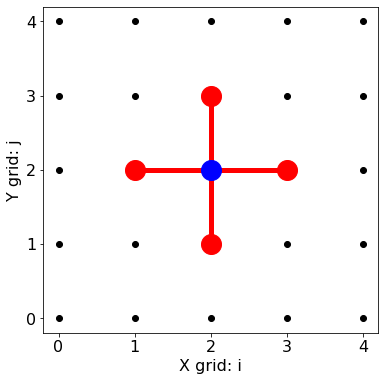

In [2]:
plt.figure(figsize=(6,6))
nx=ny=5
x,y=np.arange(nx),np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1
plt.plot(1,2,'ro',ms=20)
plt.plot(3,2,'ro',ms=20)
plt.plot([1,3],[2,2],'r-',linewidth=5)
plt.plot(2,1,'ro',ms=20)
plt.plot(2,3,'ro',ms=20)
plt.plot([2,2],[1,3],'r-',linewidth=5)
plt.plot(2,2,'bo',ms=20)

plt.ylabel('Y grid: j',fontsize=16)
plt.yticks(range(5),fontsize=16)
plt.xlabel('X grid: i',fontsize=16)
plt.xticks(range(5),fontsize=16)
plt.show()

**Figure 1. Second-order Laplacian stencil where red and blue points have a weightings of $1$ and $-4$, respectively.**

Given the finite-difference stencil in equation 4, it is thus trival to state what the **difference equation** (i.e., discrete numerical approximation) of the Laplace equation is:

$$\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + 
  \frac{\partial^2 u}{\partial y^2}
  \approx 
u_{i+1,j}+u_{i-1,j}-4u_{i,j}+u_{i,j+1}+u_{i,j-1} = 0, \tag{5}$$

where the dependence on $h^2$ has been eliminated because the right-hand side of equation 5 is zero.  However, unlike for the 1D advection equation, we no longer have a time-evolution problem! Rather, we have a [boundary value problem](https://en.wikipedia.org/wiki/Boundary_value_problem) (BVP) associated with the following solution domain:

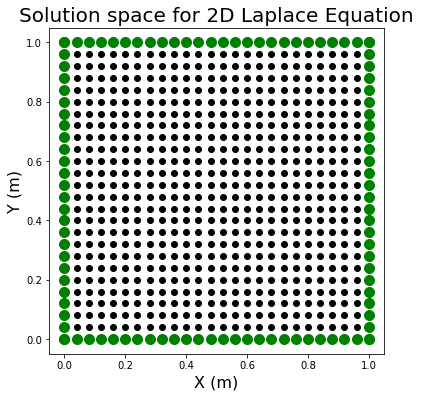

In [3]:
plt.figure(figsize=(6,6))
nx=ny=26
x,y=np.arange(nx)/(nx-1),np.zeros(ny)

for iy in range(nx):
    plt.plot(x,y,'ko')
    y+=1/(nx-1)
plt.plot(x,  np.zeros(ny),'go',ms=10)
plt.plot(x,1+np.zeros(ny),'go',ms=10)
plt.plot(np.zeros(ny),x  ,'go',ms=10)
plt.plot(np.zeros(ny)+1,x,'go',ms=10)    
plt.ylabel('Y (m)',fontsize=16)
plt.xlabel('X (m)',fontsize=16)
plt.title('Solution space for 2D Laplace Equation',fontsize=20)
plt.show()

**Figure 2. Example of a solution space for the 2D Laplace equation. Black points represent locations of unknown solution $u_{i,j}$ while those in green are fixed by the boundary conditions.  Note that the actual values of the boundary value solution (i.e., green points) do not have to be the same value; they are only shown to be so for illustration purposes.**

# Solution by ADI methods

Let's now look at a numerical approach that uses an **alternating direction implicit (ADI)** method that **iteratively** updates solutions in one direction (here $x$) and then in the second direction (here $y$).  This is similar to the split-step method discussed in the Lax-Wendroff methods in the Differentiation and Discretization section notes.

## Step 1 - Solution in the x direction

Let's first write the Laplacian stencil from above in the following manner:

$$u_{i+1,j}-4u_{i,j}+u_{i-1,j} = - u_{i,j+1}-u_{i,j-1}. \tag{6a}$$

and now hypothesize that we are introducing a **time-like** step from time level $(m)$ to $(m+1)$, where the brackets are used to indicate that this is time-like ... but not truely time. This gives us the following approximation:

$$u^{(m+1)}_{i+1,j}-4u^{(m+1)}_{i,j}+u^{(m+1)}_{i-1,j} = - u^{(m)}_{i,j+1}-u^{(m)}_{i,j-1}. \tag{6b}$$

If now we fix row $j$, we see that this represent a matrix system of equations of the form ${\bf Ax} = {\bf b}$:

$$
\left[
\begin{array}{ccccccc}
1 & 0 & 0 & 0 & ... & 0&0 &0 &0 \\
1 & -4 & 1 & 0 &... & 0&0  &0 &0 \\
0 & 1 & -4 & 1 & ... & 0&0 &0 &0 \\
\vdots & \vdots & \vdots& \vdots & \ddots & \vdots &\vdots &\vdots & \vdots\\
0 &0&0&0&...&1&-4&1&0\\
0 &0&0&0&...&0&1&-4&1\\
0 &0&0&0&...&0&0&0&1\\
\end{array}
\right]
\left[
\begin{array}{c}
u^{(m+1)}_{0,j} \\
u^{(m+1)}_{1,j} \\
u^{(m+1)}_{2,j} \\
\vdots\\
u^{(m+1)}_{I-2,j} \\
u^{(m+1)}_{I-1,j} \\
u^{(m+1)}_{I,j} \\
\end{array}
\right]
=
\left[
\begin{array}{c}
U^{(m)}_{0,j} \\
-U^{(m)}_{1,j+1} - U^{(m)}_{1,j-1} \\
-U^{(m)}_{2,j+1} - U^{(m)}_{2,j-1} \\
\vdots\\
-U^{(m)}_{I-2,j+1} - U^{(m)}_{I-2,j-1} \\
-U^{(m)}_{I-1,j+1} - U^{(m)}_{I-1,j-1} \\
U^{(m)}_{I,j} \\
\end{array}
\right]. \tag{7}
$$

where matrices ${\bf A}$ and ${\bf b}$ are known.  Note that the range of $x$-index goes from $i=0,I$ while the range of the $y$-index goes from $j=0,J$. Notice the first row and last row are different to satisfy the boundary contidions. To solve this equation, we can use some of the methods discussed in numerical linear algebra section (e.g., Gaussian Elimination) to calculate the numerical solution.  One then iterates over each $j$ row to generate the solution at pseudo time-step $(m+1)$. Thus, we have to solve the system given by equation 7 a total of $J-1$ times (because you don't have to calculate the solutions right at boundaries $j=0$ and $j=J$!).

## Step 2 - Solution in the y direction

Let's now rewrite the Laplacian stencil from above in the following manner:

$$u_{i,j+1}-4u_{i,j}+u_{i,j-1} = - u_{i+1,j}-u_{i-1,j}. \tag{8a}$$

and again hypothesize that we are going to use a **time-like** step from $(m+1)$ calculated in Step 1 above to step $(m+2)$.  This gives us the following approximation:

$$u^{(m+2)}_{i,j+2}-4u^{(m+2)}_{i,j}+u^{(m+2)}_{i,j-1} = - u^{(m+1)}_{i+1,j}-u^{(m+1)}_{i-1,j}. \tag{8b}$$

If now we fix row $i$, we see that this again represents a matrix system of equations of the form ${\bf Ax} = {\bf b}$:

$$
\left[
\begin{array}{ccccccc}
1 & 0 & 0 & 0 & ... & 0&0 &0 &0 \\
1 & -4 & 1 & 0 &... & 0&0  &0 &0 \\
0 & 1 & -4 & 1 & ... & 0&0 &0 &0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots &\vdots &\vdots &\vdots \\
0 &0&0&0&...&1&-4&1&0\\
0 &0&0&0&...&0&1&-4&1\\
0 &0&0&0&...&0&0&0&1\\
\end{array}
\right]
\left[
\begin{array}{c}
u^{(m+2)}_{i,0} \\
u^{(m+2)}_{i,1} \\
u^{(m+2)}_{i,2} \\
\vdots\\
u^{(m+2)}_{i,J-2} \\
u^{(m+2)}_{i,J-1} \\
u^{(m+2)}_{i,J  } \\
\end{array}
\right]
=
\left[
\begin{array}{c}
U^{(m+1)}_{i,0} \\
-U^{(m+1)}_{i+1,1} - U^{(m+1)}_{i-1,1} \\
-U^{(m+1)}_{i+1,2} - U^{(m+1)}_{i-1,2} \\
\vdots\\
-U^{(m+1)}_{i+1,J-2} - U^{(m+1)}_{i-1,J-2} \\
-U^{(m+1)}_{i+1,J-1} - U^{(m+1)}_{i-1,J-1} \\
U^{(m+1)}_{i,J  } \\
\end{array}
\right]. \tag{9}
$$

where matrices ${\bf A}$ and ${\bf b}$ are again known. One then iterates over each $i$ column (for a total of $I-1$ time steps because you don't have to calculate at the $i=0$ and $i=I+1$ boundaries!) to generate the solution at pseudo time-step $(m+2)$.

# Example 1 - Laplace's Equation with Variable Boundary Conditions

**QUESTION:** Let's look at an example where we want to generate a solution $u$ to the 2D Laplace's equation

$$\nabla^2u =0 \tag{10}$$

on a square solution domain defined by $x,y\in[0,3]$ where we have the following boundary conditions:

$$
\begin{eqnarray}
u(x,y=0)&=&x^4 \tag{11a} \\ 
u(x,y=3)&=&x^4-54x^2+81 \tag{11b} \\ 
u(x=0,y)&=&y^4 \tag{11c} \\
u(x=3,y)&=&y^4-54y^2+81 \tag{11d} \\
\end{eqnarray}
$$

where the known analytic solution throughout the domain is given by:

$$ u(x,y)= x^4 - 6x^2 y^2+y^4. \tag{12} $$

**ANSWER:** Let's first make it easy on ourselves by define a few helpful functions. The subroutine below defines a tridiagonal matrix where the value of the main diagonal is $b$, and the sub- and superdiagonals are $a$ and $c$, respectively, and the dimensional of the $n\times n$ matrix is $n$.  

In [2]:
def Setup_Tridiagonal(a,b,c,n):
    '''Set up regular tridiagonal matrix 
    usage: x = Gauss_elimination(A,b,print_process=False):
    input: 
        a: value along -1 subdiagonal
        b: value along main diagonal
        c: value along +1 supediagonal
        n: dimension of NxN matrix
    output:
        A: tridiagonal matrix with Dirichlet boundary condition
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    A = np.diag(a*np.ones(n-1),-1)+np.diag(b*np.ones(n),0)+np.diag(c*np.ones(n-1),1)
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0
    return A

Let's make a quick plot to visualize the function:

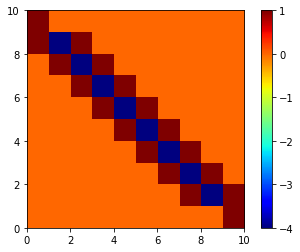

In [5]:
a=c=1
b=-4
n=10
A = Setup_Tridiagonal(a,b,c,n);
plt.figure()
plt.imshow(A,cmap='jet',extent=[0,n,0,n],vmin=b,vmax=a)
plt.colorbar()
plt.show()

**Figure 3. Looking at the tridiagonal matrix required for the 2D ADI solution.**

Let's now develop the subroutine that computes the ADI solution. Below I have witten a function that takes in current solution $U_0$ and outputs the solution after doing one iteration of the ADI method in both directions.

In [3]:
def ADI_Solution(U):
    '''Set up Alternating Direction Solution of Laplace's Equation
    usage: U = ADI_Solution(U)
    input: 
        U: starting field
    output:
        U: solution updated in both directions
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    modified by Ge Jin, gjin@mines.edu, 09/2022
    '''    
    ## . . Array dimensions from the input file
    nx,ny = np.size(U,0),np.size(U,1)
    
    ## . . Allocated dummy array to be used as a temporary solution
    U1 = np.zeros((nx,ny))
    
    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,ny-1] = U[:,ny-1]
    U1[nx-1,:] = U[nx-1,:]
    
    ## . . Define tridiagonal matrix in X
    Ax = Setup_Tridiagonal(1, -4, 1, nx)
    bx = np.zeros((nx))
    
    ## . . Define tridiagonal matrix in Y
    Ay = Setup_Tridiagonal(1, -4, 1, ny)
    by = np.zeros((ny))
    
    ## . . STEP 1 (solve in the x direction and loop over j - y)
    ## . . Note that we're writing the results to temporary array U1
    for jj in range(1,ny-1):
        bx = -U[:,jj-1]-U[:,jj+1]    
        # apply boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]
        U1[:,jj] = np.linalg.solve(Ax,bx)
        

    ## . . STEP 2 (solve in the x direction and loop over j - y)
    ## . . Note that we're now rewriting the updated result back to U 
    for ii in range(1,nx-1):
        by = -U1[ii-1,:]-U1[ii+1,:]
        # apply boundary condition
        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]
        U[ii,:] = np.linalg.solve(Ay,by)
        
    
    ## . . Return the U solution array after a complete cycle of x and y updating!
    return U

Let's now setup the solution space, state the boundary conditions, and call the solver.

In [4]:
## . . Space axis parameters
nt = 500 # number of iterations
xmin,xmax,ymin,ymax=0,3,0,3
nx,ny=50,50
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
h = xx[1]-xx[0]

## . . Initialize
U0 = np.zeros((nx,ny))

## . . Boundary Conditions
U0[:   ,0] = xx**4
U0[0   ,:] = yy**4
U0[:,ny-1] = 81-54*xx**2+xx**4
U0[nx-1,:] = 81-54*yy**2+yy**4

# . . True function values
tr = np.zeros((nx,ny))
for ix in range(nx):
    for iy in range(ny):
        tr[ix,iy]=xx[ix]**4-6*xx[ix]**2*yy[iy]**2+yy[iy]**4

# . . Plotting min/max
vmin,vmax = np.min(tr),np.max(tr)

## . . Movie solution
c = np.zeros((nx,ny,nt))

## . . Call Solution
for i in range(nt):
    c[:,:,i]=U0
    value = ADI_Solution(U0)
    U0 = value

# . . Compute error
err = np.zeros((nt))
for ii in range(nt):
    x = c[:,:,ii]
    err[ii] = np.linalg.norm(tr-x)   
    
# . . Normalize error
err=err/err[0]

## . . Animate Solution
k = 0
kskip=5

## . . Set up movie
fig,ax = plt.subplots(1,3)
fig.subplots_adjust(0,0,1,1)
fig.set_dpi(100)

def Laplace_animate(i):
    global k
    x = c[:,:,k]
    ax[0].imshow(tr,cmap='jet',extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax[0].set_title('ANALYT',fontsize=14)
    ax[1].imshow(x ,cmap='jet',extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax[1].set_title('NUM Step %s'%k,fontsize=14)
    ax[2].imshow(tr-x ,cmap='jet',extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax[2].set_title('DIFF Step %s'%k,fontsize=14)
    k += kskip
    plt.tight_layout()

## . . Call the animator
anim1 = animation.FuncAnimation(fig,
                            Laplace_animate,
                            frames=int((nt-2*kskip)/kskip),
                            interval=100)
anim1.save('./movies/Ex5_1.mp4')
plt.close()

HTML("""
<video width="800" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex5_1.mp4" type="video/mp4">
</video>
""")

**Figure 4. Movie showing the time evolution of the ADI solution. Left: Analytic solution $u(x,y)=x^4-6x^2y^2+y^4$. Center: Numerical solution animated at each solution step. Right: difference between the analytic and numerical solutions.**


We can now plot the movie.  Here, I've plotted the analytic solution (left), the numerical solution (center) and the difference between the two (right).

Now, if the analytic and numerical solutions are given by $a_{i,j}$ and $u^{(2m)}_{i,j}$, respectively, we can examine at how the overall error 

$$err(m) = \sqrt{\sum_{i,j}  \left(a_{i,j}-u^{(2m)}_{i,j}\right)^2}\tag{10}$$

changes as a function of iteration number. Here, I have plotted the error value as a function of step $m$ normalized by the error value at the first iteration $err(0)$.

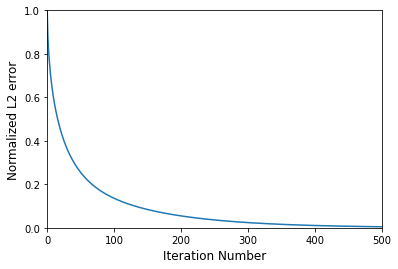

In [5]:
## . . Set up movie
fig2 = plt.figure()
plt.plot(range(nt),err)
plt.ylim(0,1)
plt.xlim(0,nt)
plt.xlabel('Iteration Number',fontsize=12),plt.ylabel('Normalized L2 error',fontsize=12)
plt.show()

**Figure 5. Least-squares error between the analytic and numerical solution. Note that it hasn't yet converged.**

# Example 2 - Poisson's Equation (Steady-state Heat with Sources)

**QUESTION:** Let's look at an example where we want to generate a solution to the 2D Poisson's equation for steady-state heat flow where there are now **heat sinks and sources** within the solution domain.  Here, we want to estimate the temperature (i.e., where u = T(x,y)) due to the distribution of the given heat sources and sinks (i.e., $F(x,y)$).  The PDE governing this is the following:

$$\nabla^2 T = -F(x,y) \tag{10}$$

where we will assume a rectilinear solution domain defined by $x,y\in[0,1]$ and that we have the following boundary conditions:

$$
\begin{eqnarray}
T(x,y=0)&=& 0 \tag{11a} \\ 
T(x,y=1)&=& 0 \tag{11b} \\ 
T(x=0,y)&=& 0 \tag{11c} \\
T(x=1,y)&=& 0 \tag{11d} \\
\end{eqnarray}
$$

where $F(x,y)$ is a forcing term given by four delta-function-like heaters and coolers:

$$F(x,y) = 
\left[
\delta\left(x-\frac{1}{4}\right)\delta\left(y-\frac{1}{4}\right)-
\delta\left(x-\frac{3}{4}\right)\delta\left(y-\frac{1}{4}\right)-
\delta\left(x-\frac{1}{4}\right)\delta\left(y-\frac{3}{4}\right)+
\delta\left(x-\frac{3}{4}\right)\delta\left(y-\frac{3}{4}\right) 
\right]. \tag{12}$$

**ANSWER:** We can reuse much of the machinary that we developed above in our solution to Laplace's equation.  However, this time we need to be careful about satisifying the forcing term $F(x,y)=F_{i,j}$.  Here, we are going to assume that $\Delta x = \Delta y = h$.  Thus, we write

$$
\begin{eqnarray}
\frac{\partial^2 T}{\partial x^2} + 
  \frac{\partial^2 T}{\partial y^2}
  &\approx & 
  \frac{T_{i+1,j}-2T_{i,j}+T_{i-1,j}}{\Delta x^2} + 
  \frac{T_{i,j+1}-2T_{i,j}+T_{i,j-1}}{\Delta y^2} = -F_{i,j}\\
  &=& 
  \frac{T_{i+1,j}+T_{i-1,j}-4T_{i,j}+T_{i,j+1}+T_{i,j-1}}{ h^2}= -F_{i,j}
  \end{eqnarray}
\tag{13}$$
  
We can then develop the following two finite-difference equations that can be used in the two-step ADI method above

**STEP 1:**

$$T^{(m+1)}_{i+1,j}-4T^{(m+1)}_{i,j}+T^{(m+1)}_{i-1,j}=  -h^2 F_{i,j}-T^{(m  )}_{i,j+1}-T^{(m  )}_{i,j-1} \tag{14a}$$

**STEP 2:**

$$T^{(m+2)}_{i,j+1}-4T^{(m+2)}_{i,j}+T^{(m+2)}_{i,j-1}=  -h^2 F_{i,j}-T^{(m+1)}_{i+1,j}-T^{(m+1)}_{i-1,j} \tag{14b}$$

Let's first adapt what we had above to include the forcing term $F(x,y)$.

In [6]:
def ADI_Solution_Forcing(U,h,F):
    '''Set up Alternating Direction Solution of Poisson Equation
    usage: U = ADI_Solution(U,h,F)
    input: 
        U: starting field
        h: sample interval
        F: Forcing Field
    output:
        U: solution updated in both directions
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''    
    ## . . Array dimensions from the input file
    nx,ny = np.size(U,0),np.size(U,1)
    
    ## . . Allocated dummy array to be used as a temporary solution
    U1 = np.zeros((nx,ny))
    
    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,ny-1] = U[:,ny-1]
    U1[nx-1,:] = U[nx-1,:]
    
    ## . . Define tridiagonal matrix in X
    Ax = Setup_Tridiagonal(1, -4, 1, nx)
    bx = np.zeros((nx))
    
    ## . . Define tridiagonal matrix in Y
    Ay = Setup_Tridiagonal(1, -4, 1, ny)
    by = np.zeros((ny))
    
    ## . . STEP 1 (solve in the x direction and loop over j - y)
    ## . . Note that we're writing the results to temporary array U1
    for jj in range(1,ny-1):
        bx = -h*h*F[:,jj]-U[:,jj-1]-U[:,jj+1]   
        # apply boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]
        U1[:,jj] = np.linalg.solve(Ax,bx)
        

    ## . . STEP 2 (solve in the x direction and loop over j - y)
    ## . . Note that we're now rewriting the updated result back to U 
    for ii in range(1,nx-1):
        by = -h*h*F[ii,:]-U1[ii-1,:]-U1[ii+1,:]
        # apply boundary condition
        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]
        U[ii,:] = np.linalg.solve(Ay,by)
        
    return U

Let's now define our solution domain, discretization, and solve below:

In [ ]:
## . . Space axis parameters
nt = 250 # number of iterations
xmin,xmax,ymin,ymax=0,1,0,1
nx,ny=100,100
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
h = xx[1]-xx[0]

## . . Set up forcing term
FF = np.zeros((nx,ny))
FF[ 25,  25]=+1.
FF[ 75,  25]=-1.
FF[ 25,  75]=-1.
FF[ 75,  75]=+1.

## . . Initialize solution
U0 = np.zeros((nx,ny)) # . . Note boundary conditions are set as well

# . . Plotting min/max
vmin,vmax = 0,1

## . . Movie solution
e = np.zeros((nx,ny,nt))
conv = np.zeros((nt)) # . . For convergence

## . . Call Solution
for i in range(nt):
    e[:,:,i]=U0
    value = ADI_Solution_Forcing(U0,h,FF)
    U0 = value
    conv[i] = np.linalg.norm(e[:,:,i]-U0)  ## . . Let's examine the convergence
conv=conv/conv[0] ## . . Normalize

In [40]:
## . . Animate Solution and compute error
k = 0
kskip=5
## . . Set up movie
fig3,ax3 = plt.subplots()
fig3.subplots_adjust(0.1,0.1,0.9,0.9)
fig3.set_dpi(100)

x = e[:,:,k]
imax = ax3.imshow(x,cmap='jet',extent=[xmin,xmax,ymin,ymax])
cbar_ax = fig3.add_axes([0.85,0.1,0.02,0.8])
# fig3.colorbar(imax,ax=cbar_ax)

def Poisson_animate(i):
    global k
    x = e[:,:,k]
    cbar_ax.cla()
    imax = ax3.imshow(x,cmap='jet',extent=[xmin,xmax,ymin,ymax])
    ax3.set(xlabel='X(m)', ylabel='Y(m)')
    ax3.set_title('NUMERICAL Step %s'%k,fontsize=14)
    fig3.colorbar(imax,cax=cbar_ax)
    k += kskip

## . . Call the animator
anim2 = animation.FuncAnimation(fig3,Poisson_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim2.save('./movies/Ex5_2.mp4')
plt.close()

HTML("""
<video width="800" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex5_2.mp4" type="video/mp4">
</video>
""")

**Figure 6. Movie showing the convergence of the numerical solution to Poisson's equation for temperature distribution $T(x,y)$ assuming two heat sources and two heat sinks where $T=0^\circ$C on the boundaries.**

We can also look at the rate at which the solution is change, which is a measure of the **rate of convergence**.  In the figure below, we see that it is changing rapidly in the first, say, 150 iterations, but then is not changing much after this. As we will see in the lab, a good way to end the simulation is the include both the maximum number of iterations as well as a **stopping criterion** when the overall solution no longer changes more than some small number $\epsilon$.

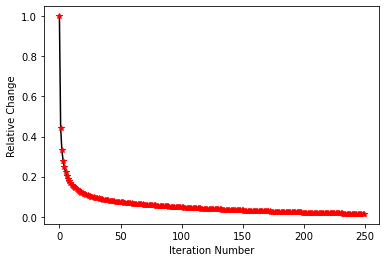

In [41]:
plt.figure()
plt.plot(range(nt),conv,'k',range(nt),conv,'r*')
plt.xlabel('Iteration Number'); plt.ylabel('Relative Change')
plt.show()

**Figure 7.  Convergence plot showing the relative change between the $(m+2)$ and $(m)$ solutions of the ADI solution method. Note that the majority of the change occurs within the first five iterations. However, by watching the movie we see that much information is actually filled during the later stages!** 

# Example 3 - Including Heterogenity

So far, we have not really looked at situations where there might be heterogeneity in the medium.  A common example would be what happens in steady-state processes (e.g., heat flow, diffusion processes) when one has material that is **spatially varying**? Let's again consider the scenario where we are examining steady-state heat flow. 

In these cases, we must look at a slightly different version of the Laplace's (or Poisson's) equation from that presented above: 

$$\nabla \cdot \left( K \nabla T\right) = 0 \tag{15a}$$

or explictly in 2D

$$ \frac{\partial}{\partial x} \left( K \frac{\partial u}{\partial x} \right)+\frac{\partial}{\partial y} \left( K \frac{\partial u}{\partial y}\right) = 0, \tag{15b}$$

where $K=K(x,y)$ is a spatially heterogeneous thermal conductivity field.  In these cases we can do something a bit different that involves taking a **second-order PDF** and breaking it down into **two first-order PDEs**.  If we let **auxilliary variables** $v$ and $w$ be defined in the following way:

$$ v = K \frac{\partial u}{\partial x}, \tag{16a}$$
$$ w = K \frac{\partial u}{\partial y}, \tag{16b}$$

then we can use them to calculate the following:

$$ \frac{\partial v}{\partial x} + \frac{\partial w}{\partial y} = 0, \tag{17}$$

which will satisfy Laplace's equation for heterogenous fields.

### Numerical solution

Let's write equation 16a and 16b in the following way that uses forward differences for the gradient operator:

$$v_{i,j} = K_{i,j}\left( \frac{ u_{i+1,j} - u_{i,j}}{h}  \right) \tag{18a} $$
$$w_{i,j} = K_{i,j}\left( \frac{ u_{i,j+1} - u_{i,j}}{h}  \right) \tag{18b} $$

we can then apply a backward difference when we apply the divergence operator:

$$ \frac{v_{i,j} - v_{i-1,j}}{h} + \frac{w_{i,j} - w_{i,j-1}}{h}=0\tag{19}$$

However, we know the value of these four numerical approximations in terms of $u_{i,j}$.  Thus, we can rewrite equation 19 as

$$ \frac{K_{i,j}\left( \frac{ u_{i+1,j} - u_{i,j}}{h}  \right)  - K_{i-1,j}\left( \frac{ u_{i,j} - u_{i-1,j}}{h}  \right)   }{h} + \frac{ K_{i,j}\left( \frac{ u_{i,j+1} - u_{i,j}}{h}  \right) - K_{i,j-1}\left( \frac{ u_{i,j} - u_{i,j-1}}{h}  \right)  }{h}=0\tag{20}$$

Noting that all of $h$ terms can be eliminated simplifies equation 20 to:

$$ K_{i,j}\left(  u_{i+1,j} - u_{i,j}  \right)  - K_{i-1,j}\left( u_{i,j} - u_{i-1,j}  \right)  +  K_{i,j}\left(  u_{i,j+1} - u_{i,j}  \right) - K_{i,j-1}\left(  u_{i,j} - u_{i,j-1}  \right)=0\tag{21}$$

Regrouping terms leads to the following:

$$K_{i,j} u_{i+1,j} - K_{i,j}u_{i,j} - K_{i-1,j}u_{i,j} + K_{i-1,j}u_{i-1,j} +K_{i,j}u_{i,j+1} - K_{i,j} u_{i,j} - K_{i,j-1}  u_{i,j} +  K_{i,j-1}u_{i,j-1}  = 0 \tag{22}$$

Collecting terms for $u_{i,j}$ gives:

$$K_{i,j} u_{i+1,j} + K_{i-1,j}u_{i-1,j} - \left(2K_{i,j}+ K_{i-1,j}+K_{i,j-1}\right) u_{i,j} + K_{i,j}u_{i,j+1} +  K_{i,j-1}u_{i,j-1}  = 0. \tag{23}$$

Note that if $K$ is constant then we recover exactly what we had in equation 4 above!

## ADI Solution

Let's follow our solution approach above by alternating the direction of the solution.  Thus, in the x-direction at pseudo-timestep $(m+1)$ we have

$$K_{i,j} u^{(m+1)}_{i+1,j} + K_{i-1,j}u^{(m+1)}_{i-1,j} - \left(2K_{i,j}+ K_{i-1,j}+K_{i,j-1}\right) u^{(m+1)}_{i,j} = - K_{i,j}u^{(m)}_{i,j+1} -  K_{i,j-1}u^{(m)}_{i,j-1}. \tag{24} $$

Similaly, in the y-direction at pseudo-timestep $(m+2)$ we will have

$$ K_{i,j}u^{(m+2)}_{i,j+1} +  K_{i,j-1}u^{(m+2)}_{i,j-1} - \left(2K_{i,j}+ K_{i-1,j}+K_{i,j-1}\right) u^{(m+2)}_{i,j} =  -K_{i,j} u^{(m+1)}_{i+1,j} - K_{i-1,j}u^{(m+1)}_{i-1,j}. \tag{25} $$

Evidently, we now no longer have spatially constant coefficients.  However, because we still have the same structure, we can still solve using a similar approach! Let's first create a subroutine that allows us to set up a tridiagonal system, but with heterogeneous coefficients.

In [36]:
def Setup_Tridiagonal_Heterogeneous(a,b,c,n):
    '''Set up regular tridiagonal matrix 
    usage: x = Gauss_elimination(A,b,print_process=False):
    input: 
        a: values along -1 diagonal (n-1 vector length)
        b: values along 0  diagonal (n   vector length)
        c: values along +1 diagonal (n-1 vector length)
        n: dimension of NxN matrix
    output:
        A: tridiagonal matrix with Dirichlet Boundary Condition
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    A = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0
    return A

We can then modify our solution mechanism above to incorporate the spatially varying coefficients.  

In [43]:
def ADI_Solution_Heterogeneous(U,K):
    '''Set up Alternating Direction Solution of Laplace Equation in Heterogeneous media
    usage: U = ADI_Solution(U,K)
    input: 
        U: starting field
        K: Heterogenerous Diffusion field (function of x and y)
    output:
        U: solution updated in both directions
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''    
    nx,ny = np.size(U,0),np.size(U,1)
    U1    = np.zeros((nx,ny))
    
    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,ny-1] = U[:,ny-1]
    U1[nx-1,:] = U[nx-1,:]
    
    ## . . Coefficients for x
    axmat = np.zeros((nx-1))
    bxmat = np.zeros((nx  ))
    cxmat = np.zeros((nx-1))
    bx    = np.zeros((nx  ))

    ## . . Coefficients for x
    aymat = np.zeros((ny-1))
    bymat = np.zeros((ny  ))
    cymat = np.zeros((ny-1))
    by    = np.zeros((ny  ))

    ## . . Loop over j (y)
    for jj in range(1,ny-1):
        
        axmat = K[0:nx-1,jj]
        bxmat = -2.*K[:,jj]-K[:,jj-1]-np.insert(K[0:nx-1,jj],0,0)
        cxmat = K[1:nx  ,jj]
        
        ## . . have to set this up each time b/c is heterogeneous now
        Ax = Setup_Tridiagonal_Heterogeneous(axmat,bxmat,cxmat,nx)
        bx = -np.multiply(K[:,jj],U[:,jj+1]) - np.multiply(K[:,jj-1],U[:,jj-1])
        
        # force boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]
                                       
        U1[:,jj] = np.linalg.solve(Ax,bx)
        

    ## . . Loop over i (x)
    for ii in range(1,nx-1):
        aymat =     K[ii,0:ny-1]
        bymat = -2.*K[ii,:     ]-K[ii-1,:]-np.insert(K[ii,0:ny-1],0,0)
        cymat =     K[ii,1:ny  ]

        ## . . have to set this up each time b/c is heterogeneous now
        Ay = Setup_Tridiagonal_Heterogeneous(aymat,bymat,cymat,ny)
        by = -np.multiply(K[ii,:],U1[ii+1,:]) - np.multiply(K[ii-1,:],U1[ii-1,:])
        
        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]
        
        U[ii,:] = np.linalg.solve(Ay,by)
        
    return U

In [44]:
## . . Space axis parameters
nt = 250 # number of iterations
xmin,xmax,ymin,ymax=0,3,0,3
nx,ny=50,50
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
h = xx[1]-xx[0]

## . . Initialize
U0 = np.zeros((nx,ny))

## . . Boundary Conditions
U0[:   ,0] = xx**4
U0[0   ,:] = yy**4
U0[:,ny-1] = 81-54*xx**2+xx**4
U0[nx-1,:] = 81-54*yy**2+yy**4

# . . Plotting min/max
vmin,vmax = np.min(U0),np.max(U0)

## . . Heterogeneous solution
xxx, yyy = np.meshgrid(xx, yy, sparse=True)
K = np.zeros((nx,ny))+1 - 0.75*np.exp((-(xxx-3)**2-(yyy-3)**2))+np.exp((-(xxx-0)**2-(yyy-3)**2))+np.exp((-(xxx-3)**2-(yyy-0)**2))
Kmin,Kmax = np.min(K),np.max(K)

## . . Movie solution
f = np.zeros((nx,ny,nt))

## . . Call Solution
for i in range(nt):
    f[:,:,i]=U0
    value = ADI_Solution_Heterogeneous(U0,K)
    U0 = value

## . . Animate Solution and compute error
k = 0
kskip = 5

## . . Set up movie
fig4,ax4 = plt.subplots(1,3)
fig4.subplots_adjust(0,0,1,1)
fig4.set_dpi(100)

def Laplace_heterogeneous_animate(i):
    global k
    x = f[:,:,k]
    y = c[:,:,k]
    ax4[0].imshow(K,cmap='jet',extent=[xmin,xmax,ymin,ymax],vmin=Kmin,vmax=Kmax)
    ax4[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax4[0].set_title('K(x,y)',fontsize=12)
    ax4[1].imshow(x ,cmap='jet',extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax4[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax4[1].set_title('K(x,y) Step %s'%k,fontsize=12)
    ax4[2].imshow(y ,cmap='jet',extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax4[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax4[2].set_title('K const Step %s'%k,fontsize=12)
    k += kskip
    plt.tight_layout()

## . . Call the animator
anim4 = animation.FuncAnimation(fig4,Laplace_heterogeneous_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim4.save('./movies/Ex5_3.mp4')
plt.close()

HTML("""
<video width="800" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex5_3.mp4" type="video/mp4">
</video>
""")

**Figure 8. Illustration of the differences in solution when using a spatially varying thermal conductivity field.  The left panel shows a thermal conductivity $K(x,y)$ that is a function of the two spatial coordinates. The middel panel shows how the solution evolves using a solver that takes $K(x,y)$ into account.  The right panel is for the homogeneous $K_0$ solution above.  Evidently, the blue regions on the right tend to slow down the evolution of the thermal solution, while those in the red do the opposite.**